In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import torch as th 
import torch.nn as nn
import torchvision.transforms as transforms
import pickle

**Image segmentation** is an important task in  computer vision. The goal is to find multiple areas in an image and to assign labels to these area.  It provides a different kind of information than: 
- **image classification** caracterizes images with global labels;
- **object detection** usually relies on finding bounding-boxes around  detected objects

Segmentation is useful and can be used in real-world applications such as medical imaging, clothes segmentation, flooding maps, self-driving cars, etc. There are two types of image segmentation:
- Semantic segmentation: classify each pixel with a label.
- Instance segmentation: classify each pixel and differentiate each object instance.

U-Net is a semantic segmentation technique [originally proposed for medical imaging segmentation](https://arxiv.org/abs/1505.04597). It’s one of the earlier deep learning segmentation models. This architecture is still widely used in more advanced models like Generative Adversarial or Diffusion Network. 

The model architecture is fairly simple: an encoder (for downsampling) and a decoder (for upsampling) with skip connections. U-Net is only based on convolutions. More specifically, the output classification is done at pixel level with a *(1,1)* convolution. It has therefore  the following advantages: 
- parameter and data efficiency, 
- independent of the input size. 

The following image is taken from the original paper:

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png"  width="60%" height="30%">


The goal of this lab session is to develop the U-Net architecture for image semantic segmentation. To start we will consider a binary segmentation task.  

#  Cell nuclei segmentation: the dataset

Cell nuclei segmentation is an essential step in the biological analysis of microscopy images. 
This segmentation can be manually achieved with dedicated software, however it is very costly. 
In this lab session, the starting point is this [nature paper](https://www.nature.com/articles/s41597-020-00608-w). To quote some part of the paper: 

Fully-automated nuclear image segmentation is the prerequisite to ensure statistically significant, quantitative analyses of tissue preparations,applied in digital pathology or quantitative microscopy. The design of segmentation methods that work independently of the tissue type or preparation is complex, due to variations in nuclear morphology, staining intensity, cell density and nuclei aggregations. Machine learning-based segmentation methods can overcome these challenges, however high quality expert-annotated images are required for training. Currently, the limited number of annotated fluorescence image datasets publicly available do not cover a broad range of tissues and preparations. We present a comprehensive, annotated dataset including tightly aggregated nuclei of multiple tissues for the training of machine learning-based nuclear segmentation algorithms. The proposed dataset covers sample preparation methods frequently used in quantitative immunofluorescence microscopy. 

To spare some preprocessing time, this lab session starts with this pickle

In [4]:
import gzip
fn = "nuclei_cells_segmentations.pck.gz"
f = gzip.open(fn, 'rb')
X, Y = pickle.load(f)
Xtrain = X[0:70]
Ytrain = Y[0:70]
Xvalid = X[70:79]
Yvalid = Y[70:79]
print(X.shape, Y.shape)
N = X.shape[0]

torch.Size([79, 1, 128, 128]) torch.Size([79, 1, 128, 128])


This pickle contains a modified version of the dataset: 
- the same amount of images
- all the images are resized to 128,128
- the segmentation task is converted in a binary pixel classification: nuclei or not. 

The goal is now to train a U-Net on this dataset (70 images for training and 9 for "test"). 

# U-Net

Following the previous picture of U-Net, the network is composed of 3 parts: encoder, bottleneck, decoder.  
These three steps rely on a convolutional block (convolution, relu, convolution, relu) 

The first step is the **encoder**. The goal is to compress the  "geometrical" information with local features. The encoder first applies a convolution of kernel size (3,3) to extract $F=64$ features. Then the information is compressed using max-pooling (factor 2). The next step does the same:  extract $2\times F=128$ features from the $F=64$, then compression with max-pooling. This operation is repeated 4 times in total to get at the end $F\times 8 = 512$ channels that represent global features extracted from the input image. 

The **bottleneck** layer is a convolutional layer which doubles the number of channels. The idea is to create a "dense" representation of the image to gather both global and local features. 

The **decoder** part is similar to the encoder part but reversed. While we used max-pooling for downsampling in the encoder, the upsampling operation consists in **transposed convolution**. The goal is to increase (so upsample) the spatial dimensions of intermediate feature maps. 

The last peculiarity is the output layer for classification at the pixel level. In U-Net this last layer is (once again) a convolutional layer. This means that with the last hidden layer, we recover the same spatial dimension as the input with $F$ feature maps. The classification is carried out for each pixel independently, but the decision is based on $F$ features that encode global information. 


## ConvTranspose2D

In pytorch, transposed convolution is achieved with the module ConvTranspose2D (for images or 2D objects).
To better understand how it works, it can be useful to play with it. 


In [27]:
c = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, bias=True)
print(c.weight, c.bias)
c(X[1]).size()

Parameter containing:
tensor([[[[-0.1868, -0.0206],
          [-0.1148, -0.1430]]]], requires_grad=True) Parameter containing:
tensor([0.3953], requires_grad=True)


torch.Size([1, 129, 129])

As you can see, the operation is parametrized by a convolution mask $\mathbf{W}$ and one bias term. For one value $v$ in the input, we get as output $v\times\mathbf{W}+b$. As an illustration, we can consider a simple image with one channel. To start, it is easier to start without the bias term: 


In [42]:
im = th.zeros(1,1,2,2)
c = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, bias=False)
print("The weights: ",c.weight)
for i in range(4):
    im = th.zeros(1,1,2,2)
    im[0,0,i%2,i//2] = 1
    print("image: ",im)
    print("output: ",c(im))

The weights:  Parameter containing:
tensor([[[[-0.0397,  0.2538],
          [-0.0567,  0.2124]],

         [[ 0.2228,  0.2427],
          [-0.0593, -0.1089]]]], requires_grad=True)
image:  tensor([[[[1., 0.],
          [0., 0.]]]])
output:  tensor([[[[-0.0397,  0.2538,  0.0000],
          [-0.0567,  0.2124,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],

         [[ 0.2228,  0.2427,  0.0000],
          [-0.0593, -0.1089,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]]], grad_fn=<ConvolutionBackward0>)
image:  tensor([[[[0., 0.],
          [1., 0.]]]])
output:  tensor([[[[ 0.0000,  0.0000,  0.0000],
          [-0.0397,  0.2538,  0.0000],
          [-0.0567,  0.2124,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.2228,  0.2427,  0.0000],
          [-0.0593, -0.1089,  0.0000]]]], grad_fn=<ConvolutionBackward0>)
image:  tensor([[[[0., 1.],
          [0., 0.]]]])
output:  tensor([[[[ 0.0000, -0.0397,  0.2538],
          [ 0.0000, -0.0567,  0.2124],
          [ 0.0000,

Try now with an image full of 1 and explain the result: 

In [37]:
im = th.ones(1,1,2,2)  # Here we use a 2x2 image full of 1

S = th.zeros(1,1,3,3)  # Here we use the sum of the convolutions on 4 2x2 images with each one 1 in a different position
for i in range(4):
    im_2 = th.zeros(1,1,2,2)
    im_2[0,0,i%2,i//2] = 1
    S += c(im_2)

print("We compare the two results:\n",S==c(im))

We compare the two results:
 tensor([[[[True, True, True],
          [True, True, True],
          [True, True, True]]]])


The convolution works the same if we sum the images or the transformed images.

Now we can consider different stride: 

In [39]:
c = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=2,  bias=False)
print(c.weight)
for i in range(4): 
    print("...")
    im = th.zeros(1,1,2,2)
    im[0,0,i%2,i//2] = 1
    print(im)
    print(c(im))

Parameter containing:
tensor([[[[ 0.4163, -0.2296],
          [-0.1997, -0.2218]]]], requires_grad=True)
...
tensor([[[[1., 0.],
          [0., 0.]]]])
tensor([[[[ 0.4163, -0.2296,  0.0000,  0.0000],
          [-0.1997, -0.2218,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]]]],
       grad_fn=<ConvolutionBackward0>)
...
tensor([[[[0., 0.],
          [1., 0.]]]])
tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.4163, -0.2296,  0.0000,  0.0000],
          [-0.1997, -0.2218,  0.0000,  0.0000]]]],
       grad_fn=<ConvolutionBackward0>)
...
tensor([[[[0., 1.],
          [0., 0.]]]])
tensor([[[[ 0.0000,  0.0000,  0.4163, -0.2296],
          [ 0.0000,  0.0000, -0.1997, -0.2218],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]]]],
       grad_fn=<ConvolutionBackward0>)
...
tensor([[[[0., 0.],
          [0., 1.]]]])
tenso

Try to understand the previous and the next examples and how it can be used to upsample. 

In [41]:
c = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=2,  bias=False)
print(c.weight)

S= th.zeros(1,1,4,4)
for i in range(4): 
    im_2 = th.zeros(1,1,2,2)
    im_2[0,0,i%2,i//2] = 1
    S += c(im_2)

im = th.ones(1,1,2,2)
c(im)

print("We compare the two results:\n",S==c(im))

Parameter containing:
tensor([[[[-0.3030,  0.4502],
          [ 0.3835, -0.1332]]]], requires_grad=True)
We compare the two results:
 tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]]]])


We upscaled a 2x2 image in a 4x4 image using a linear and "reversable" transformation.

## U-Net: step by step

Now the goal is to implement U-Net. As a proposed roadmap we propose the following step: 
- a function to create a convolutional block
- a module for the encoder
- a module for the decoder
- and a U-Net module to wrap everything

The number of feature map ($F=64$ in the original work) must be a variable of the UNet. For the first round of experiment, we can use $F=8$.  


**TODO:**
- run the training on the 70 first images and spare the last 9 for evaluation
- after the training process, look at the results on some training images and the evaluation ones. 


In [5]:
def conv_block(in_channels, out_channels,kernel):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=kernel, padding=1),
        nn.ReLU(inplace=True)
    )

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels,kernel):
        super(Encoder, self).__init__()
        self.conv = conv_block(in_channels, out_channels,kernel)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        encoded = self.pool(x)
        return encoded , x

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels,kernel):
        super(Decoder, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = conv_block(in_channels, out_channels,kernel)

    def forward(self, x, encoded):
        x = self.up(x)
        x = th.cat([encoded, x], dim=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels,kernel, f):
        super(UNet, self).__init__()
        self.f = f
        self.encoder1 = Encoder(in_channels, self.f, kernel)
        self.encoder2 = Encoder(self.f, self.f * 2, kernel)
        self.encoder3 = Encoder(self.f * 2, self.f * 4, kernel)
        self.encoder4 = Encoder(self.f * 4, self.f * 8, kernel)

        self.bottom_block = conv_block(self.f * 8, self.f * 16, kernel)

        self.decoder4 = Decoder(self.f * 16, self.f * 8, kernel)
        self.decoder3 = Decoder(self.f * 8, self.f * 4, kernel)
        self.decoder2 = Decoder(self.f * 4, self.f * 2, kernel)
        self.decoder1 = Decoder(self.f * 2, self.f, kernel)

        self.final_conv = nn.Conv2d(self.f,out_channels,kernel_size = 1, padding = 0)

    def forward(self, x):
        encoded1 , x1 = self.encoder1(x)
        encoded2 , x2 = self.encoder2(encoded1)
        encoded3 , x3 = self.encoder3(encoded2)
        encoded4 , x4 = self.encoder4(encoded3)
 
        bottom_end = self.bottom_block(encoded4)

        decoded4 = self.decoder4(bottom_end, x4)
        decoded3 = self.decoder3(decoded4 , x3)
        decoded2 = self.decoder2(decoded3 , x2)
        decoded1 = self.decoder1(decoded2 , x1)

        f_conv = self.final_conv(decoded1)

        return f_conv


In [124]:
loss_fn = nn.BCEWithLogitsLoss()
print(loss_fn(X,Y))

tensor(18.4115)


In [6]:
def train_U_net(model,loss_fn, Nepochs=30,l_r =0.001,verbose=False):
    # The verbose allows you to skip printed information per epoch.
    # The function will only print the best accuracy on the validation
    # and plot the learning curves. 
    optimizer=th.optim.Adam(model.parameters(),lr=l_r)
    train_losses = np.zeros(Nepochs+1)
    valid_losses = np.zeros(Nepochs+1)
    
    ### Mini-batching and shuffle 
    Ntrain = Xtrain.shape[0] 
    Nvalid = Xvalid.shape[0]
    idx = np.arange(Ntrain) # Generate the indices 
    batch_size = Ntrain
    nbatch = int(Ntrain/batch_size) # the number of batches
    train_losses[0] = loss_fn(model(Xtrain),Ytrain)
    valid_losses[0] = loss_fn(model(Xvalid),Yvalid)

    for epochs in range(Nepochs):
        ids = np.random.shuffle(idx)
        for b in range(nbatch):
            ids = idx[b*batch_size:(b+1)*batch_size] # Get indices
            images = Xtrain[ids]  # Get the images
            labels = Ytrain[ids]  # The Labels
            optimizer.zero_grad()
            logprobs=model(images) # inference 
            loss=loss_fn(logprobs,labels) # compute the loss
            loss.backward() # Back propagation
            optimizer.step() # update the parameters
        train_losses[epochs+1] = loss_fn(model(Xtrain),Ytrain)
        with th.no_grad():
            valid_losses[epochs+1] = loss_fn(model(Xvalid),Yvalid)

    #topclass = th.exp(model(Xvalid)).topk(1,dim = 1)[1]
    
    #final_accuracy = th.sum(topclass == Yvalid.view(*topclass.shape)) / Nvalid
    final_train_loss = loss_fn(model(Xtrain),Ytrain)
    final_valid_loss = loss_fn(model(Xvalid),Yvalid)

    # plots
    plt.figure(figsize = (15, 1.5))
    ax= plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('loss on training set')
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    ax.set_ylim(bottom=0)

    ax= plt.subplot(1, 2, 2)
    plt.plot(valid_losses)
    plt.title('loss on validation set')
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    ax.set_ylim(bottom=0)

    # prints
    print('The final loss on the training set of our model is:', final_train_loss)
    print('The final loss on the validation set of our model is:', final_valid_loss)
    #print('The final accuracy of our model is:', final_accuracy)


The final loss on the training set of our model is: tensor(0.6174, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
The final loss on the validation set of our model is: tensor(0.6125, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
The final loss on the training set of our model is: tensor(0.6048, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
The final loss on the validation set of our model is: tensor(0.5994, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


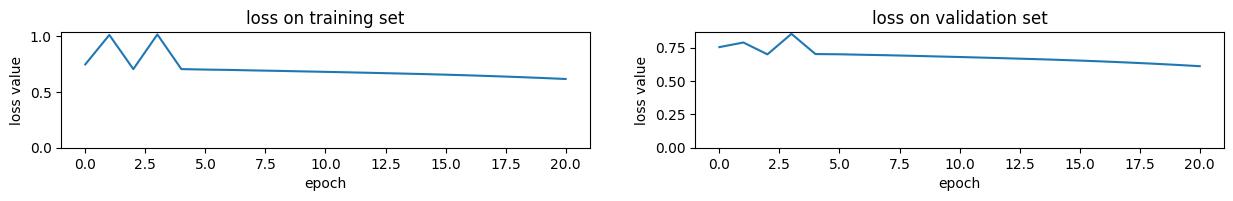

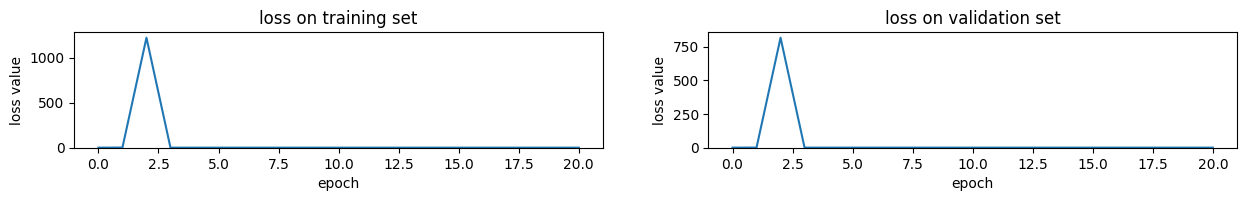

In [15]:
model_1 = UNet(1,1,3,8)
model_2 = UNet(1,1,3,16)

train_U_net(model_1, nn.BCEWithLogitsLoss(),20,0.01)
train_U_net(model_2, nn.BCEWithLogitsLoss(),20,0.01)

## Precision and recall

For segmentation, it can be meaningful to look at the precision and recall. 
- The precision for the class 1 (a nucleus) is the ratio between the number of true positives for the class 1  and the total of pixels classified as nuclei by the model. 
- The recall is the ratio between the number of pixels of class 1 correctly classified and the total of pixels classified that should be classified as nuclei. 
These measures depend on a threshold of the output score. While the "natural" threshold is $0$ on the output score (or $0.5$ if the model outputs probabilities), we can consider different tradeoff between precision and recall by varying the threshold. 

**TODO:**
- Make a function which computes precision and recall for a given threshold
- Plot the precision recall curve for a threshold varying between -5 and +5
- Compare 2 models with respectively $F=8$ and $16$. 


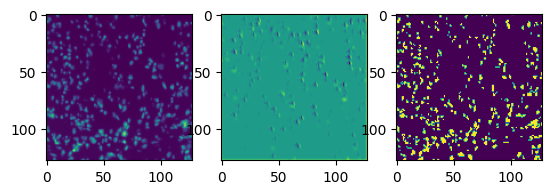

In [18]:
plt.subplot(1,3,1)
plt.imshow(Xtrain[1].squeeze())
plt.subplot(1,3,2)
plt.imshow(model_1(Xtrain[1:2]).squeeze().detach().numpy())
plt.subplot(1,3,3)
plt.imshow(Ytrain[1].squeeze())


In [39]:
def compute_precision(Pred, Truth, threshold):
    pred_flat = Pred.flatten().detach().numpy()
    Truth_flat = Truth.flatten().detach().numpy()

    pred_bin = (pred_flat>=threshold)
    
    True_pos = ((pred_bin == 1) & (Truth_flat == 1))
    True_neg = ((pred_bin == 0) & (Truth_flat == 0))
    False_pos = ((pred_bin == 1) & (Truth_flat == 0))
    False_neg = ((pred_bin == 0) & (Truth_flat == 1))

    Precision = np.sum(True_pos) / (np.sum(True_pos) + np.sum(False_pos))
    Recall = np.sum(True_pos) / np.sum(Truth_flat)

    return Precision, Recall

In [60]:
Thresholds = np.linspace(-5,5,50)
P_1 = model_1(X)
P_2 = model_2(X)
Precisions = []
Recalls = []

for _ in Thresholds:
    Prec_1, Rec_1 = compute_precision(P_1,Y,_)
    Prec_2, Rec_2 = compute_precision(P_2,Y,_)
    Precisions.append((Prec_1,Prec_2))
    Recalls.append((Rec_1,Rec_2))


C:\Users\lerou\AppData\Local\Temp\ipykernel_11540\413795246.py:12: RuntimeWarning: invalid value encountered in scalar divide
  Precision = np.sum(True_pos) / (np.sum(True_pos) + np.sum(False_pos))


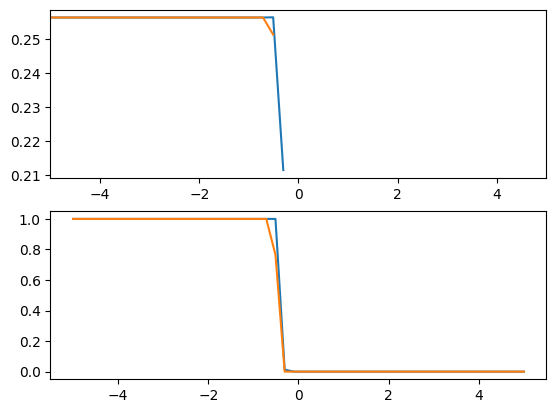

In [61]:
precisions = np.array(Precisions)
recalls = np.array(Recalls)
# Plot the precision-recall curve
plt.subplot(2,1,1)
plt.plot(Thresholds,precisions)
plt.xlim((-5,5))
plt.subplot(2,1,2)
plt.plot(Thresholds,recalls)

# Data Augmentation 
When the dataset is scarce, we can try data-augmentation. The idea is to apply transformation introduce diversity in the dataset with basic transformation. [Look at this page for more information](https://pytorch.org/vision/main/transforms.html). 

**TODO:**
- Select a couple of transformation
- Evaluate the impact of data-augmentation on our task.


